# FashionMNIST Dataset with PyTorch

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

## PyTorch's `Dataset` & `Dataloader`

* `torch.utils.data.Dataset`: allow preloading datasets or one's own data.
* `torch.utils.data.DataLoader`: wraps an iterable around the `Dataset` to enable easy access.

### Load FashionMNIST

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

/home/nhat/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize the Dataset

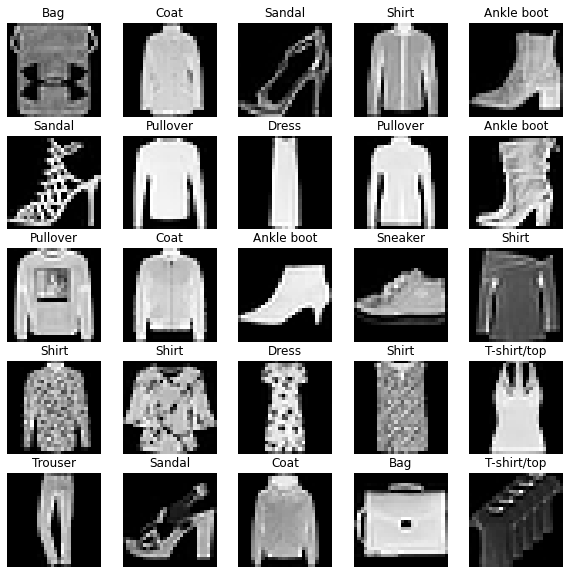

In [3]:
import matplotlib.pyplot as plt

# Specify the size of the visualization
figure = plt.figure(figsize=(10, 10))
# Specify how many samples we want to visualize
rows, cols = 5, 5
# Visualize
for i in range(rows * cols):
    # Pick one sample
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # Add subplot for that sample
    figure.add_subplot(rows, cols, i + 1)
    plt.title(train_data.classes[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
# Show all subplots
plt.show()

### Create a Custom Dataset for your files

* Instead of loading a dataset from the library, you can create a custom dataset from your own files. See [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files).

### Prepare data for training with DataLoaders

During training, we would typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's `multiprocessing` to speed up data retrieval. `DataLoader` is an iterable that abstracts all that in the following API:

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Iterate through the `DataLoader`

We can then use the `DataLoader` objects to iterate through the data in minibatches.

Each iteration below returns a batch of `train_features` and `train_labels` with `batch_size=64`. Since `shuffle=True`, after we iterate over all batches the data is shuffled.

In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.shape)

torch.Size([64, 1, 28, 28])


## Data Preparation with Transforms

We use **transforms** to perform some manipulation of the data and make it suitable for training.

All TorchVision datasets have two parameters:
* `transform`: modify the features
* `target_transform`: modify the labels

These parameters accept callables containing the transformation logic. The `torchvision.transforms` module offers several commonly-used transform out of the box.

For the `FashionMNIST` dataset:

* We use `ToTensor` to convert PIL images or NumPy `ndarray` into normalized `FloatTensor` with pixel intensity values in the range `[0., 1.]`.
* We use `Lambda` and a lambda function to transform the labels into one-hot encoded tensors. The `scatter_` method assigns a `value=1` on the index given by the label `y`.

In [6]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(len(datasets.FashionMNIST.classes), dtype=torch.float)
                       .scatter_(0, torch.tensor(y), value=1)
    )
)

## Build The Neural Network

### Get Device For Training

We may want to use GPU if it is available. Otherwise, we can use the CPU.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


### Define the network

In [8]:
from torch import nn

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Flatten 2D 28x28 image into 1D
        self.flatten = nn.Flatten()
        # The layers
        self.layers = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=10),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

### Create the model

In [9]:
model = NeuralNet().to(device)
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


### Call the model on an input

In [10]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
prob_predict = nn.Softmax(dim=1)(logits)
y_predict = prob_predict.argmax(1)
print(f'Predicted class: {y_predict}')

Predicted class: tensor([6], device='cuda:0')


## Automatic Differentiation with `torch.autograd`

### Tensors, Functions and Computational graph

`torch.autograd` supports automatic computation of gradient for any computational graph.

For example: Consider the simplest one-layer network with:
* input `x`
* parameters `w` and `b`
* expected output `y`

![](https://pytorch.org/tutorials/_images/comp-graph.png)

In [11]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(loss)

tensor(1.1587, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


For each tensor, there is an object of class `Function` that knows how to compute the function in the forward direction and also how to compute its derivative during backpropagation. A reference to the backward propagation function is stored in `grad_fn` property of a tensor.

In [12]:
print('Gradient function for z: ', z.grad_fn)
print('Gradient function for loss: ', loss.grad_fn)

Gradient function for z:  <AddBackward0 object at 0x7f9035bce4f0>
Gradient function for loss:  <BinaryCrossEntropyWithLogitsBackward object at 0x7f9035bce520>


### Compute Gradients

We calculate $\frac{\partial loss}{\partial w}$ and $\frac{\partial loss}{\partial b}$ by calling `loss.backward()`. The values can be retrieve from `w.grad` and `b.grad`.

* Note that:
    * We can only obtain the grad properties for the leaf nodes of the computational graph, which have `requires_grad` property set to `True`. For all other nodes in our graph, gradients will not be available.
    * We can only perform gradient calculations using `backward` once on a given graph, for performance reasons. If we need to do several `backward` calls on the same graph, we need to pass `retain_graph=True` to the `backward` call.

In [13]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2711, 0.1571, 0.2289],
        [0.2711, 0.1571, 0.2289],
        [0.2711, 0.1571, 0.2289],
        [0.2711, 0.1571, 0.2289],
        [0.2711, 0.1571, 0.2289]])
tensor([0.2711, 0.1571, 0.2289])


### Disabling Gradient Tracking

There are reasons you might want to disable gradient tracking:
* To mark some parameters in your neural network at frozen parameters. This is a very common scenario for finetuning a pretrained network.
* To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

By default, all tensors with `requires_grad=True` are tracking their computational history and support gradient computation. We can stop tracking computations by surrounding our computation code with `torch.no_grad()` block.

In [14]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the `detach()` method on the tensor:

In [15]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


### More on Computational Graphs

Conceptually, autograd keeps a record of data (tensors) and all executed operations (along with the resulting new tensors) in a directed acyclic graph (DAG) consisting of Function objects. In this DAG, leaves are the input tensors, roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

* run the requested operation to compute a resulting tensor
* maintain the operation’s gradient function in the DAG

The backward pass kicks off when `.backward()` is called on the DAG root. autograd then:

* computes the gradients from each `.grad_fn`
* accumulates them in the respective tensor’s `.grad` attribute
* using the chain rule, propagates all the way to the leaf tensors

Note: **DAGs are dynamic in PyTorch**. An important thing to note is that the graph is recreated from scratch; after each .backward() call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed.

### Optional Reading: Tensor Gradients and Jacobian Products

[See here](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#optional-reading-tensor-gradients-and-jacobian-products)

## Optimizing Model

### Hyperparameters

* Number of Epochs
* Batch size - number of samples seen by the model in each epoch
* Learning rate

In [16]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

### Optimization Loop

Each iteration of the optimization loop is an epoch.

Each epoch consists of two main parts:

* **The train loop** - iterate over the training dataset and try to converge to optimal parameters.
* **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

### Loss Function

Common loss functions:
* `nn.MSELoss`
* `nn.NLLLoss` (Negative Log Likelihood)
* `nn.CrossEntropyLoss`

### Optimizer

Optimization algorithms includes SGD, ADAM, RMSProp, etc.

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Train loop & Test loop

Inside the training loop, optimization happens in three steps:

1. Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
2. Backpropagate the prediction loss with a call to `loss.backwards()`. PyTorch deposits the gradients of the loss w.r.t. each parameter.
3. Once we have our gradients, we call `optimizer.step()` to adjust the parameters by the gradients collected in the backward pass.


In [32]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Train Model

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.234776  [    0/60000]
loss: 2.251633  [ 6400/60000]
loss: 2.199684  [12800/60000]
loss: 2.208983  [19200/60000]
loss: 2.206764  [25600/60000]
loss: 2.172766  [32000/60000]
loss: 2.152596  [38400/60000]
loss: 2.224848  [44800/60000]
loss: 2.097842  [51200/60000]
loss: 2.121495  [57600/60000]
Test Error: 
 Accuracy: 30.7%, Avg loss: 0.033558 

Epoch 2
-------------------------------
loss: 2.196215  [    0/60000]
loss: 2.048948  [ 6400/60000]
loss: 2.047350  [12800/60000]
loss: 2.136779  [19200/60000]
loss: 2.077750  [25600/60000]
loss: 2.044441  [32000/60000]
loss: 2.087986  [38400/60000]
loss: 2.047635  [44800/60000]
loss: 2.087465  [51200/60000]
loss: 1.998566  [57600/60000]
Test Error: 
 Accuracy: 33.1%, Avg loss: 0.031705 

Epoch 3
-------------------------------
loss: 2.049419  [    0/60000]
loss: 2.009570  [ 6400/60000]
loss: 2.096662  [12800/60000]
loss: 1.931656  [19200/60000]
loss: 1.971477  [25600/60000]
loss: 1.786666  [32000/600

## Save & Load Model

[See here](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html)